In [62]:
import os
import streamlit as st
import pickle
import time
import langchain
from langchain import OpenAI
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.chains.qa_with_sources.loading import load_qa_with_sources_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredURLLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS

/Users/napolean/Downloads/LLAMA_chat/say2shop-2/s2s_cs/lib/python3.11/site-packages/langchain/__init__.py:24: UserWarning: Importing OpenAI from langchain root module is no longer supported.
  warnings.warn(


In [3]:
import openai
from dotenv import load_dotenv

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
openai.api_key = openai_api_key

In [63]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-3.5-turbo")

In [15]:
import pandas as pd
df = pd.read_csv("data/BigBazaar_vector_db_1.csv",index_col=0)


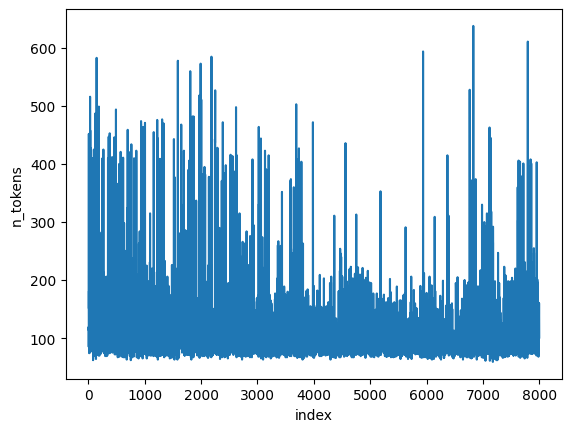

In [18]:
#plot a graph of the n_tokens vs index
import matplotlib.pyplot as plt
plt.plot(df.n_tokens)
plt.ylabel('n_tokens')
plt.xlabel('index')
plt.show()

In [19]:
#sort the dataframe by n_tokens and reset the index
df = df.sort_values(by=['n_tokens'])
df = df.reset_index(drop=True)

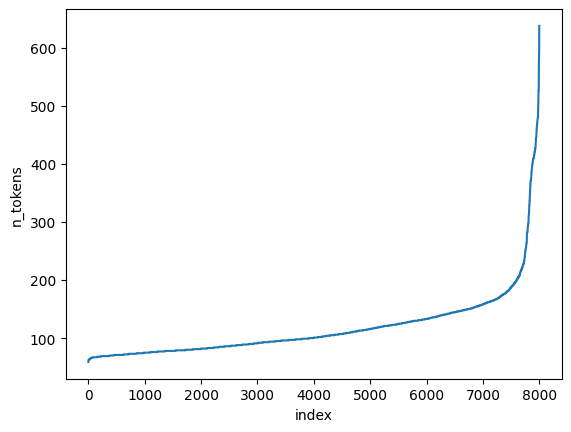

In [20]:
#plot a graph of the n_tokens vs index
import matplotlib.pyplot as plt
plt.plot(df.n_tokens)
plt.ylabel('n_tokens')
plt.xlabel('index')
plt.show()

In [28]:
#delete all rows whose n_tokens is greater than 300
df = df[df.n_tokens < 170]

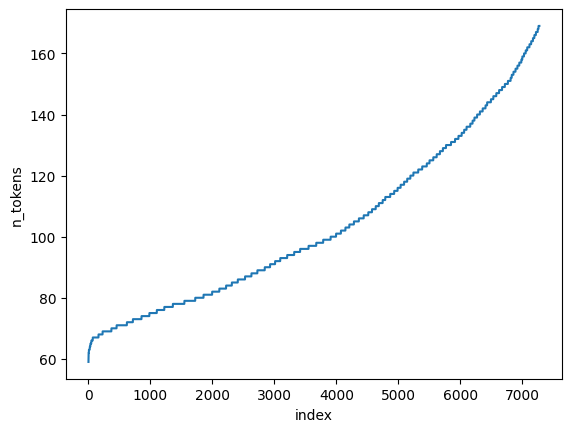

In [29]:
#plot a graph of the n_tokens vs index
import matplotlib.pyplot as plt
plt.plot(df.n_tokens)
plt.ylabel('n_tokens')
plt.xlabel('index')
plt.show()

In [30]:
#print length of dataframe and total number of tokens
print(len(df))
print(sum(df.n_tokens))

7278
753413


In [32]:
#save the dataframe as a csv file
df.to_csv("data/BigBazaar_vector_db_1.csv")

In [68]:
df = pd.read_csv("data/BigBazaar_head_1000_vector_db.csv",index_col=0)

In [70]:
#remove 1st and 2nd row from dataframe
df = df.drop(df.index[[0,1]])

In [74]:
# remove last 4 columns from dataframe
df = df.iloc[:, :-4]

In [75]:
df = df.reset_index(drop=True)

In [77]:
df.to_csv("data/BigBazaar_head_1000.csv")

In [35]:
import numpy as np
import ast
# Apply ast.literal_eval to convert the strings back to lists
df['embedding'] = df['embedding'].apply(ast.literal_eval)
vectors = df.embedding.to_list()
vectors = np.array(vectors)
vectors.shape


(7278, 1536)

In [37]:
import faiss

vector_dimension = vectors.shape[1]
index = faiss.IndexFlatL2(vector_dimension)
index.add(vectors)

In [39]:
print(index.ntotal)

7278


In [40]:
# Storing vector index create in local
file_path="vector_index.pkl"
with open(file_path, "wb") as f:
    pickle.dump(index, f)

In [78]:
from langchain.document_loaders.csv_loader import CSVLoader
loader = CSVLoader(file_path="data/BigBazaar_head_1000.csv")
data = loader.load()

In [79]:
len(data)

998

In [80]:
embeddings = OpenAIEmbeddings(model = "text-embedding-ada-002")

In [81]:
vectorindex_openai = FAISS.from_documents(data, embeddings)

In [82]:
data[0]

Document(page_content=": 0\nName: Mixing Bowl - Oven & Microwave Safe, 900 ml\nBrand: BOROSIL\nPrice: 410\nDiscountedPrice: 369.0\nBreadCrumbs: Cooking and Baking / Bakeware\nCategory: Cooking and Baking\nSubCategory: Bakeware\nQuantity: 1 Pcs\nDescription: \nLongDescription: Colour TransparentPattern BowlItem Dimensions LxWxH 19.5 x 9.8 x 19.5 CentimetersCapacity 900 MillilitersIs Dishwasher Safe YesAbout this itemUnlike plastic and melamine will not leech chemicals into your food even over repeated usageNon porous glass will not absorb stains or odorsCan be used in a microwave or electric oven, not for use over direct flameDo not use plastic lids in the microwaveColor: Transparent, Material: GlassPackage Contents: 1-Piece Mixing Bowl (900ml) with LidWarranty: 2 years warranty against manufacturing defectsColor:Transparent, Material:GlassPackage Contents: 1-Piece Mixing Bowl (900ml) with LidWarranty: 2 years warranty against manufacturing defectsYou demand the best of yourself, so it'

In [83]:
file_path="vector_index_BigBazaar_head_1000.pkl"
with open(file_path, "wb") as f:
    pickle.dump(vectorindex_openai, f)

In [84]:
if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        vectorIndex = pickle.load(f)

In [85]:
chain = RetrievalQAWithSourcesChain.from_llm(llm=llm, retriever=vectorIndex.as_retriever())
chain

RetrievalQAWithSourcesChain(memory=None, callbacks=None, callback_manager=None, verbose=False, tags=None, metadata=None, combine_documents_chain=MapReduceDocumentsChain(memory=None, callbacks=None, callback_manager=None, verbose=False, tags=None, metadata=None, input_key='input_documents', output_key='output_text', llm_chain=LLMChain(memory=None, callbacks=None, callback_manager=None, verbose=False, tags=None, metadata=None, prompt=PromptTemplate(input_variables=['context', 'question'], output_parser=None, partial_variables={}, template='Use the following portion of a long document to see if any of the text is relevant to answer the question. \nReturn any relevant text verbatim.\n{context}\nQuestion: {question}\nRelevant text, if any:', template_format='f-string', validate_template=True), llm=ChatOpenAI(cache=None, verbose=False, callbacks=None, callback_manager=None, tags=None, metadata=None, client=<class 'openai.api_resources.chat_completion.ChatCompletion'>, model_name='gpt-3.5-tur

In [87]:
query = "suggest me some good deals on toothpaste"
# query = "what are the main features of punch iCNG?"

langchain.debug=True

chain({"question": query}, return_only_outputs=True)

[chain/start] [1:chain:RetrievalQAWithSourcesChain] Entering Chain run with input:
{
  "question": "suggest me some good deals on toothpaste"
}
[chain/start] [1:chain:RetrievalQAWithSourcesChain > 3:chain:MapReduceDocumentsChain] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:RetrievalQAWithSourcesChain > 3:chain:MapReduceDocumentsChain > 4:chain:LLMChain] Entering Chain run with input:
{
  "input_list": [
    {
      "context": ": 97\nName: Toothpaste Cavity Protection\nBrand: Pepsodent\nPrice: 132\nDiscountedPrice: 87.99\nBreadCrumbs: Personal Care / Oral Care\nCategory: Personal Care\nSubCategory: Oral Care\nQuantity: 300 g(2x150 g)\nDescription: \nLongDescription: For strong, white teeth, get the Germicheck+  Toothpaste from Pepsodent. The germicheck formula helps fight cavity-causing germs even 12 hours after brushing. Formulated with fluoride and natural activated clay formula, this toothpaste ensures that you have a long-lasting fresh breath. It reduces stains an

{'answer': 'Here are some good deals on toothpaste:\n\n1. Pepsodent Germicheck+ Toothpaste value pack: Save Rs.17.\n2. Price: 182, DiscountedPrice: 121.32.\n3. Price: 105, DiscountedPrice: 105.0.\n4. DiscountedPrice: 93.0.\n\nPlease note that these deals are sourced from the Big Bazaar dataset.',
 'sources': ''}